In [ ]:
# Packages imports
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import seaborn as sns
from math import ceil
import matplotlib.pyplot as plt
import sqlite3
import datetime
from sklearn.linear_model import LinearRegression

In [ ]:
# import tables
countries = pd.read_csv("countries.csv")
industries = pd.read_csv("industries.csv")
payouts = pd.read_csv("payouts.csv")

In [ ]:
# check out the first few rows of "payouts" table
payouts.head()

,date,platform_id,recipient_id,count,amount
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_23d90ec275370c686dedd7dc1c5e93b3,1,9786.0
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,id_72f05535ba5e6e5b141db6b5c1f1b13b,1,3750.0
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,id_d70e8046fe5583e1154b2e077133e27c,1,2258.0
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_1a336bd21b4bfd9810e0510e1a5f7ec2,1,20369.0
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_c577aeddec71607ec0be1f94bef025da,1,34922.0


In [ ]:
# Change date format, convert cents to hundred thousands dollars, add weekday column (Monday = 0, Tuesday = 1, etc.)
payouts['date'] = pd.to_datetime(payouts['date']).dt.date
payouts['amount_in_100000_$'] = payouts['amount'].div(100000)
payouts['weekday'] = pd.to_datetime(payouts['date']).dt.dayofweek

# Merge payouts with countries
merged_payouts_countries = pd.merge(payouts[['platform_id', 'amount_in_100000_$', 'weekday']],
                                    countries,
                                    how='left',
                                    left_on='platform_id',
                                    right_on='merchant_id')

# Filter out rows with missing country data (less than 1% of payouts)
merged_payouts_countries.dropna(subset=['country'], inplace=True)

# Select useful columns into the new table
merged_payouts_countries = merged_payouts_countries[['platform_id', 'amount_in_100000_$', 'weekday', 'country']]


In [ ]:
# Group amounts by weekday and country
merged_payouts_countries = merged_payouts_countries.groupby(['weekday', 'country'], as_index=False).sum()

# Further group the data by weekday to get the total payouts for each weekday
merged_payouts_countries_2 = merged_payouts_countries.groupby('weekday', as_index=False).agg({'amount_in_100000_$': 'sum'})


<ipython-input-60-4dc6045fd153>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_payouts_countries = merged_payouts_countries.groupby(['weekday', 'country'], as_index=False).sum()


In [ ]:
merged_payouts_countries_2

,weekday,amount_in_100000_$
0,0,197256.09180
1,1,294788.57747
2,2,243729.02733
3,3,201119.72979
4,4,149770.76544
5,5,104487.73777
6,6,153803.15840


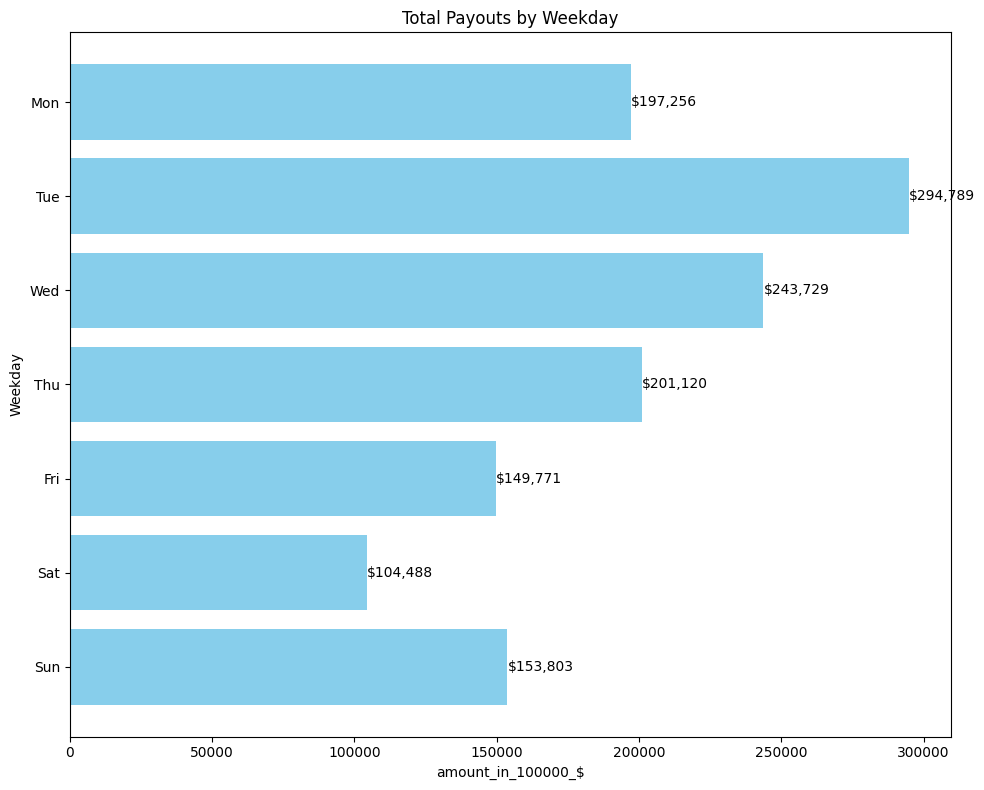

In [ ]:
# Sort the data by amount_in_100000_$ for better visualization
merged_payouts_countries_2 = merged_payouts_countries_2.sort_values('amount_in_100000_$', ascending=False)

plt.figure(figsize=(10, 8))
bars = plt.barh(merged_payouts_countries_2['weekday'], merged_payouts_countries_2['amount_in_100000_$'], color='skyblue')
plt.xlabel('amount_in_100000_$')
plt.ylabel('Weekday')
plt.title('Total Payouts by Weekday')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top

# Add data labels to the bars with dollar sign
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'${bar.get_width():,.0f}',
             va='center', ha='left', fontsize=10)

# Adjusting x-axis ticks to show weekday names
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.yticks(merged_payouts_countries_2['weekday'], [weekday_names[i] for i in merged_payouts_countries_2['weekday']])

plt.tight_layout()
plt.show()


- Tuesday, representing weekday 1, notably stands out with the highest payout compared to other days. This observation becomes valuable when estimating payouts for Jan. 1, 2019, as it aligns with a Tuesday. This consistent pattern across multiple Tuesdays throughout the year allows us to leverage this information for predictions.

- We can simplify our estimation process by assuming a consistent payout behavior on Tuesdays. Therefore, by aggregating the total payouts across all Tuesdays in 2018 for each country and dividing these totals by 52, we can determine the average payout amount expected on a typical Tuesday.

# **Question 1:**
An estimate for the amount of money we should expect to be paid out to each country on Jan 1, *2019*

In [ ]:
#total payouts on all Tuesdays in 2018 by country
#merged_payouts_countries =
merged_payouts_countries[merged_payouts_countries['weekday']== 1]


,weekday,country,amount_in_100000_$
25,1,AT,8.33813
26,1,AU,343.43218
27,1,BE,95.37942
28,1,BR,151.05664
29,1,CA,9436.07060
30,1,CH,18.24067
31,1,DE,11110.75710
32,1,DK,90.43760
33,1,ES,8.05326
34,1,FI,41.23499


In [ ]:
# Filter data for Tuesdays
tuesday_payouts = merged_payouts_countries[merged_payouts_countries['weekday'] == 1]

# Calculate expected payout for Jan 1, 2019
tuesday_payouts['expected_amount_Jan_1_2019_in_100000_$'] = tuesday_payouts['amount_in_100000_$'] / 52
tuesday_payouts


<ipython-input-64-89b39151cda2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuesday_payouts['expected_amount_Jan_1_2019_in_100000_$'] = tuesday_payouts['amount_in_100000_$'] / 52


,weekday,country,amount_in_100000_$,expected_amount_Jan_1_2019_in_100000_$
25,1,AT,8.33813,0.160349
26,1,AU,343.43218,6.604465
27,1,BE,95.37942,1.834220
28,1,BR,151.05664,2.904935
29,1,CA,9436.07060,181.462896
30,1,CH,18.24067,0.350782
31,1,DE,11110.75710,213.668406
32,1,DK,90.43760,1.739185
33,1,ES,8.05326,0.154870
34,1,FI,41.23499,0.792981


- Approximately $5.2 million is the average payout made to the US on each Tuesday, constituting over 91% of all payouts to all countries on this day.
- The amounts paid out to each country on 1st January 2019 are listed in the 4th column.
- For a more accurate forecast of payouts to each country on 1st January 2019, a Time-Series model like SARIMA, which accommodates trend and seasonality, would be effective. However, developing this model exceeds the time frame allocated for this project (6 hours).

In [ ]:
# Create a DataFrame for daily total count and amount
daily_count = payouts.groupby('date', as_index=False)['count'].sum()
daily_amount = payouts.groupby('date', as_index=False)['amount_in_100000_$'].sum()

# Calculate daily average payout
daily_avg_payout = payouts.groupby('date', as_index=False)['amount_in_100000_$'].mean()
daily_avg_payout.rename(columns={'amount_in_100000_$': 'avg_payout_in_100000_$'}, inplace=True)

# Calculate median and 25th/75th percentiles for payouts by country
daily_median_payout = payouts.groupby('date', as_index=False)['amount_in_100000_$'].median()
daily_percent_25_payout = payouts.groupby('date', as_index=False)['amount_in_100000_$'].quantile(0.25)
daily_percent_75_payout = payouts.groupby('date', as_index=False)['amount_in_100000_$'].quantile(0.75)

daily_percent_75_payout

,date,amount_in_100000_$
0,2018-01-01,0.877517
1,2018-01-02,0.769900
2,2018-01-03,0.993955
3,2018-01-04,0.840828
4,2018-01-05,0.833803
...,...,...
360,2018-12-27,0.690500
361,2018-12-28,1.019602
362,2018-12-29,0.979110
363,2018-12-30,0.726422


# **Question 2:**
Assume that one year from the end of the dataset, we will have 15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage. How much total payout volume do you expect to see on a typical day in 2019, from these three industries?


 Notice that four merchants assigned to industries appearing only once in the dataset, which could be attributed to potential manual errors. For simplification, we are reassigning certain industries: Financial Services and Real Estate will now fall under Professional Services (non-medical), internet software & services will be categorized as Other Software & Content, and hotels, restaurants & leisure will be grouped under the Travel & Hospitality industry.

In [ ]:
# groupby industries to see the frquency
industries['industry'].value_counts()

Other Software & Content                             26037
Travel & Hospitality                                 18370
Other Services                                       15902
Professional Services (non-medical)                  14527
Food & Beverage                                      12221
Non-profit                                            9269
Tickets: concerts,sports,movies,conventions           8081
Content                                               4730
Education                                             1010
Retail Fashion                                         994
Other Retail                                           603
Healthcare                                             389
Direct Services: classes,memberships,appointments      171
Financial Services                                       1
internet software & services                             1
Real Estate                                              1
hotels, restaurants & leisure                           

In [ ]:
industries['industry'] = industries['industry'].str.replace('hotels, restaurants & leisure','Travel & Hospitality')
industries['industry'] = industries['industry'].str.replace('Real Estate','Professional Services (non-medical)')
industries['industry'] = industries['industry'].str.replace('internet software & services','Other Software & Content')
industries['industry'] = industries['industry'].str.replace('Financial Services','Professional Services (non-medical)')#

In [ ]:
#check for the new frequency table
industries['industry'].value_counts()

Other Software & Content                             26038
Travel & Hospitality                                 18371
Other Services                                       15902
Professional Services (non-medical)                  14529
Food & Beverage                                      12221
Non-profit                                            9269
Tickets: concerts,sports,movies,conventions           8081
Content                                               4730
Education                                             1010
Retail Fashion                                         994
Other Retail                                           603
Healthcare                                             389
Direct Services: classes,memberships,appointments      171
Name: industry, dtype: int64

In [ ]:
#create another table and delete some useless columns
payouts_4 = payouts.copy()
payouts_4 = payouts_4.drop(['date','recipient_id', 'count'], axis = 1)
merged_payouts_industries = pd.merge(payouts_4, industries, how='left',left_on = 'platform_id',right_on = 'merchant_id')

In [ ]:
merged_payouts_industries

,platform_id,amount,amount_in_100000_$,weekday,merchant_id,industry
0,id_5dded1fc8ff3f8c0d96019076394d2a7,9786.0,0.09786,2,id_5dded1fc8ff3f8c0d96019076394d2a7,"Tickets: concerts,sports,movies,conventions"
1,id_424316eb0d974bebd1736fc4bd2eac3d,3750.0,0.03750,4,id_424316eb0d974bebd1736fc4bd2eac3d,Travel & Hospitality
2,id_3702c1be346117616974e4127c952ab7,2258.0,0.02258,1,id_3702c1be346117616974e4127c952ab7,Content
3,id_a1eafb7ca12772d4e8770b9b3566e608,20369.0,0.20369,1,id_a1eafb7ca12772d4e8770b9b3566e608,Non-profit
4,id_a1eafb7ca12772d4e8770b9b3566e608,34922.0,0.34922,6,id_a1eafb7ca12772d4e8770b9b3566e608,Non-profit
...,...,...,...,...,...,...
1622637,id_5dded1fc8ff3f8c0d96019076394d2a7,26284.0,0.26284,3,id_5dded1fc8ff3f8c0d96019076394d2a7,"Tickets: concerts,sports,movies,conventions"
1622638,id_4fbd94bb830c62816abb07d6544bd707,8632.0,0.08632,1,id_4fbd94bb830c62816abb07d6544bd707,Other Services
1622639,id_296420e88b94f7b67b7bb305ac82a0e4,33243.0,0.33243,2,id_296420e88b94f7b67b7bb305ac82a0e4,Food & Beverage
1622640,id_48ba75d17cfea6d24ca5ba8dd72559a0,11882.0,0.11882,3,id_48ba75d17cfea6d24ca5ba8dd72559a0,Education


In [ ]:
#there are 463 unique platforms
merged_payouts_industries['platform_id'].nunique()

463

In [ ]:
breakdown_platforms_industries = merged_payouts_industries.groupby('industry')['platform_id'].nunique()
breakdown_platforms_industries

industry
Content                                                6
Direct Services: classes,memberships,appointments      7
Education                                              5
Food & Beverage                                       15
Healthcare                                             5
Non-profit                                            16
Other Retail                                          10
Other Services                                       105
Other Software & Content                             179
Professional Services (non-medical)                   26
Retail Fashion                                        19
Tickets: concerts,sports,movies,conventions           10
Travel & Hospitality                                  13
Name: platform_id, dtype: int64

In [ ]:
# only less than 1% of payouts don't have industry so we can drop them
merged_payouts_industries.info()
#drop the payouts which don't have industry
merged_payouts_industries.dropna(subset=['industry'], inplace=True)
#remove unneccessary columns
merged_payouts_industries = merged_payouts_industries[["amount_in_100000_$","weekday","merchant_id","industry"]]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1622642 entries, 0 to 1622641
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   platform_id         1622642 non-null  object 
 1   amount              1622642 non-null  float64
 2   amount_in_100000_$  1622642 non-null  float64
 3   weekday             1622642 non-null  int64  
 4   merchant_id         1622437 non-null  object 
 5   industry            1622432 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 86.7+ MB


In [ ]:
merged_payouts_industries_grouped = merged_payouts_industries.groupby(['industry','weekday'], as_index=False).sum()
relevant_industries = ['Education','Food & Beverage', 'Travel & Hospitality']
selected_industries = merged_payouts_industries_grouped[merged_payouts_industries_grouped['industry'].isin(relevant_industries)]

<ipython-input-74-f3ff93538306>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_payouts_industries_grouped = merged_payouts_industries.groupby(['industry','weekday'], as_index=False).sum()


We have a detailed breakdown of daily payouts facilitated by Education, Food & Beverage, and Travel & Hospitality platforms. Tuesdays observed the highest total payouts from platforms within the Education and Travel & Hospitality sectors, whereas Wednesdays recorded the highest total payouts for platforms associated with the Food & Beverage industry in 2018.

In [ ]:
selected_industries

,industry,weekday,amount_in_100000_$
14,Education,0,6628.09847
15,Education,1,9448.33509
16,Education,2,5089.68407
17,Education,3,4424.26442
18,Education,4,36.12140
19,Education,5,25.77729
20,Education,6,3850.28749
21,Food & Beverage,0,5313.78348
22,Food & Beverage,1,4496.76394
23,Food & Beverage,2,24021.95057


- In the breakdown below, currently we have 15 platforms in the Food & Beverage industry, 5 in Education industry and 13 in Travel and Hospitality industry.

- Since we're expecting an increase number of platforms in the Education (15) and Food & Beverage (40) industries and a decrease in the Travel & Hospitality industry (5), we need to multiply the total payouts by respective coefficients.

In [ ]:
# Breakdown for selected industries
breakdown_platforms_industries[['Food & Beverage','Education','Travel & Hospitality']]

industry
Food & Beverage         15
Education                5
Travel & Hospitality    13
Name: platform_id, dtype: int64

In [ ]:
education = selected_industries[selected_industries.industry == 'Education']
food_beverage = selected_industries[selected_industries.industry == 'Food & Beverage']
travel_hospitality = selected_industries[selected_industries.industry == 'Travel & Hospitality']
#multiply payout by expected growth in the number of platforms by industry
travel_hospitality['amount_expected_in_100000'] = travel_hospitality['amount_in_100000_$']*(5/13)
travel_hospitality['amount_expected_in_100000_per_day'] = travel_hospitality['amount_expected_in_100000']/52
food_beverage['amount_expected_in_100000'] = food_beverage['amount_in_100000_$']*(40/15)
food_beverage['amount_expected_in_100000_per_day'] = food_beverage['amount_expected_in_100000']/52
education['amount_expected_in_100000'] = education['amount_in_100000_$']*3
education['amount_expected_in_100000_per_day'] = education['amount_in_100000_$']*(15/5)

<ipython-input-77-1557b1d9cadd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_hospitality['amount_expected_in_100000'] = travel_hospitality['amount_in_100000_$']*(5/13)
<ipython-input-77-1557b1d9cadd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_hospitality['amount_expected_in_100000_per_day'] = travel_hospitality['amount_expected_in_100000']/52
<ipython-input-77-1557b1d9cadd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [ ]:
travel_hospitality

,industry,weekday,amount_in_100000_$,amount_expected_in_100000,amount_expected_in_100000_per_day
84,Travel & Hospitality,0,5892.46359,2266.332150,43.583311
85,Travel & Hospitality,1,8636.22718,3321.625838,63.877420
86,Travel & Hospitality,2,6437.26413,2475.870819,47.612900
87,Travel & Hospitality,3,4986.03013,1917.703896,36.878921
88,Travel & Hospitality,4,2447.14092,941.208046,18.100155
89,Travel & Hospitality,5,941.68479,362.186458,6.965124
90,Travel & Hospitality,6,5307.99933,2041.538204,39.260350


In [ ]:
food_beverage

,industry,weekday,amount_in_100000_$,amount_expected_in_100000,amount_expected_in_100000_per_day
21,Food & Beverage,0,5313.78348,14170.089280,272.501717
22,Food & Beverage,1,4496.76394,11991.370507,230.603279
23,Food & Beverage,2,24021.95057,64058.534853,1231.894901
24,Food & Beverage,3,4034.60499,10758.946640,206.902820
25,Food & Beverage,4,1833.65797,4889.754587,94.033742
26,Food & Beverage,5,742.27226,1979.392693,38.065244
27,Food & Beverage,6,1736.78160,4631.417600,89.065723


In [ ]:
education

,industry,weekday,amount_in_100000_$,amount_expected_in_100000,amount_expected_in_100000_per_day
14,Education,0,6628.09847,19884.29541,19884.29541
15,Education,1,9448.33509,28345.00527,28345.00527
16,Education,2,5089.68407,15269.05221,15269.05221
17,Education,3,4424.26442,13272.79326,13272.79326
18,Education,4,36.12140,108.36420,108.36420
19,Education,5,25.77729,77.33187,77.33187
20,Education,6,3850.28749,11550.86247,11550.86247





After getting the expected average payouts on each typical day of the week, we can calculate the total expected payout by each relevant industry in 2019.



In [ ]:
# Grouping and calculating total payouts for each industry
industry_totals = selected_industries.groupby('industry', as_index=False).sum()
industry_totals = industry_totals.drop(['weekday'], axis=1)
# Extracting individual industry totals
education_total = industry_totals[industry_totals['industry'] == 'Education']
food_beverage_total = industry_totals[industry_totals['industry'] == 'Food & Beverage']
travel_hospitality_total = industry_totals[industry_totals['industry'] == 'Travel & Hospitality']


In [ ]:
# Multiply payout by expected growth in the number of platforms by industry

# Travel & Hospitality calculations
travel_hospitality_total['amount_per_day_current'] = travel_hospitality_total['amount_in_100000_$'] / 365
travel_hospitality_total['amount_expected_in_100000'] = travel_hospitality_total['amount_in_100000_$'] * (5 / 13)
travel_hospitality_total['amount_expected_in_100000_per_day'] = travel_hospitality_total['amount_expected_in_100000'] / 365

# Food & Beverage calculations
food_beverage_total['amount_per_day_current'] = food_beverage_total['amount_in_100000_$'] / 365
food_beverage_total['amount_expected_in_100000'] = food_beverage_total['amount_in_100000_$'] * (40 / 15)
food_beverage_total['amount_expected_in_100000_per_day'] = food_beverage_total['amount_expected_in_100000'] / 365

# Education calculations
education_total['amount_per_day_current'] = education_total['amount_in_100000_$'] / 365
education_total['amount_expected_in_100000'] = education_total['amount_in_100000_$'] * 3
education_total['amount_expected_in_100000_per_day'] = education_total['amount_expected_in_100000'] / 365


<ipython-input-82-3530cf3ebd19>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_hospitality_total['amount_per_day_current'] = travel_hospitality_total['amount_in_100000_$'] / 365
<ipython-input-82-3530cf3ebd19>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_hospitality_total['amount_expected_in_100000'] = travel_hospitality_total['amount_in_100000_$'] * (5 / 13)
<ipython-input-82-3530cf3ebd19>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

We can see that platforms from the Food & Beverage industry are expected to have the highest payouts in 2019, while Travel & Hospitality platforms the least payouts.

In [ ]:
travel_hospitality_total

,industry,amount_in_100000_$,amount_per_day_current,amount_expected_in_100000,amount_expected_in_100000_per_day
2,Travel & Hospitality,34648.81007,94.928247,13326.465412,36.510864


In [ ]:
food_beverage_total

,industry,amount_in_100000_$,amount_per_day_current,amount_expected_in_100000,amount_expected_in_100000_per_day
1,Food & Beverage,42179.81481,115.561136,112479.50616,308.163031


In [ ]:
education_total

,industry,amount_in_100000_$,amount_per_day_current,amount_expected_in_100000,amount_expected_in_100000_per_day
0,Education,29502.56823,80.828954,88507.70469,242.486862
